<a href="https://colab.research.google.com/github/Rupak1703/Low-Light-Object-Detection-DL-/blob/main/ProjectH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Object Detection In Low Light Conditions**

## **1. Imports**

In [ ]:
!pip install ultralytics roboflow opencv-python matplotlib tqdm

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from ultralytics import YOLO
from roboflow import Roboflow
import shutil
import pandas as pd


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 59.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 

## **2. Load Dataset**

In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="LB3OBDo3iFw2LaFRu4DA")
project = rf.workspace("object-detection-in-low-light-conditions").project("low-light-sxzx2-kmskm")
version = project.version(1)
dataset = version.download("yolov8")

dataset.location



import os

dataset_root = dataset.location  # base dataset folder

train_path = os.path.join(dataset_root, "train/images")
train_label_path = os.path.join(dataset_root, "train/labels")

valid_path = os.path.join(dataset_root, "valid/images")
test_path = os.path.join(dataset_root, "test/images")

print("Train Images:", train_path)
print("Train Labels:", train_label_path)



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Low-light-1 in yolov8:: 100%|██████████| 2012/2012 [00:00<00:00, 6063.81it/s]

Train Images: /content/Low-light-1/train/images
Train Labels: /content/Low-light-1/train/labels


## **3. Enhancement Function**

In [ ]:
def enhance_image(img):
    # --- Gamma Correction ---
    gamma = 1.5
    img_gamma = cv2.pow(img / 255.0, gamma) * 255
    img_gamma = np.clip(img_gamma, 0, 255).astype(np.uint8)

    # --- Histogram Equalization ---
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    img_he = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

    # --- CLAHE (replace Retinex) ---
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    lab[:, :, 0] = clahe.apply(lab[:, :, 0])
    img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    return img_gamma, img_he, img_clahe


In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm

# Gamma Correction
def gamma_correct(img, gamma=1.8):
    inv = 1.0 / gamma
    table = np.array([(i/255.0)**inv * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(img, table)

# CLAHE
def clahe_enhance(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

# Histogram Equalization
def hist_eq(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)



## **4. Visualisations of Enhancements**

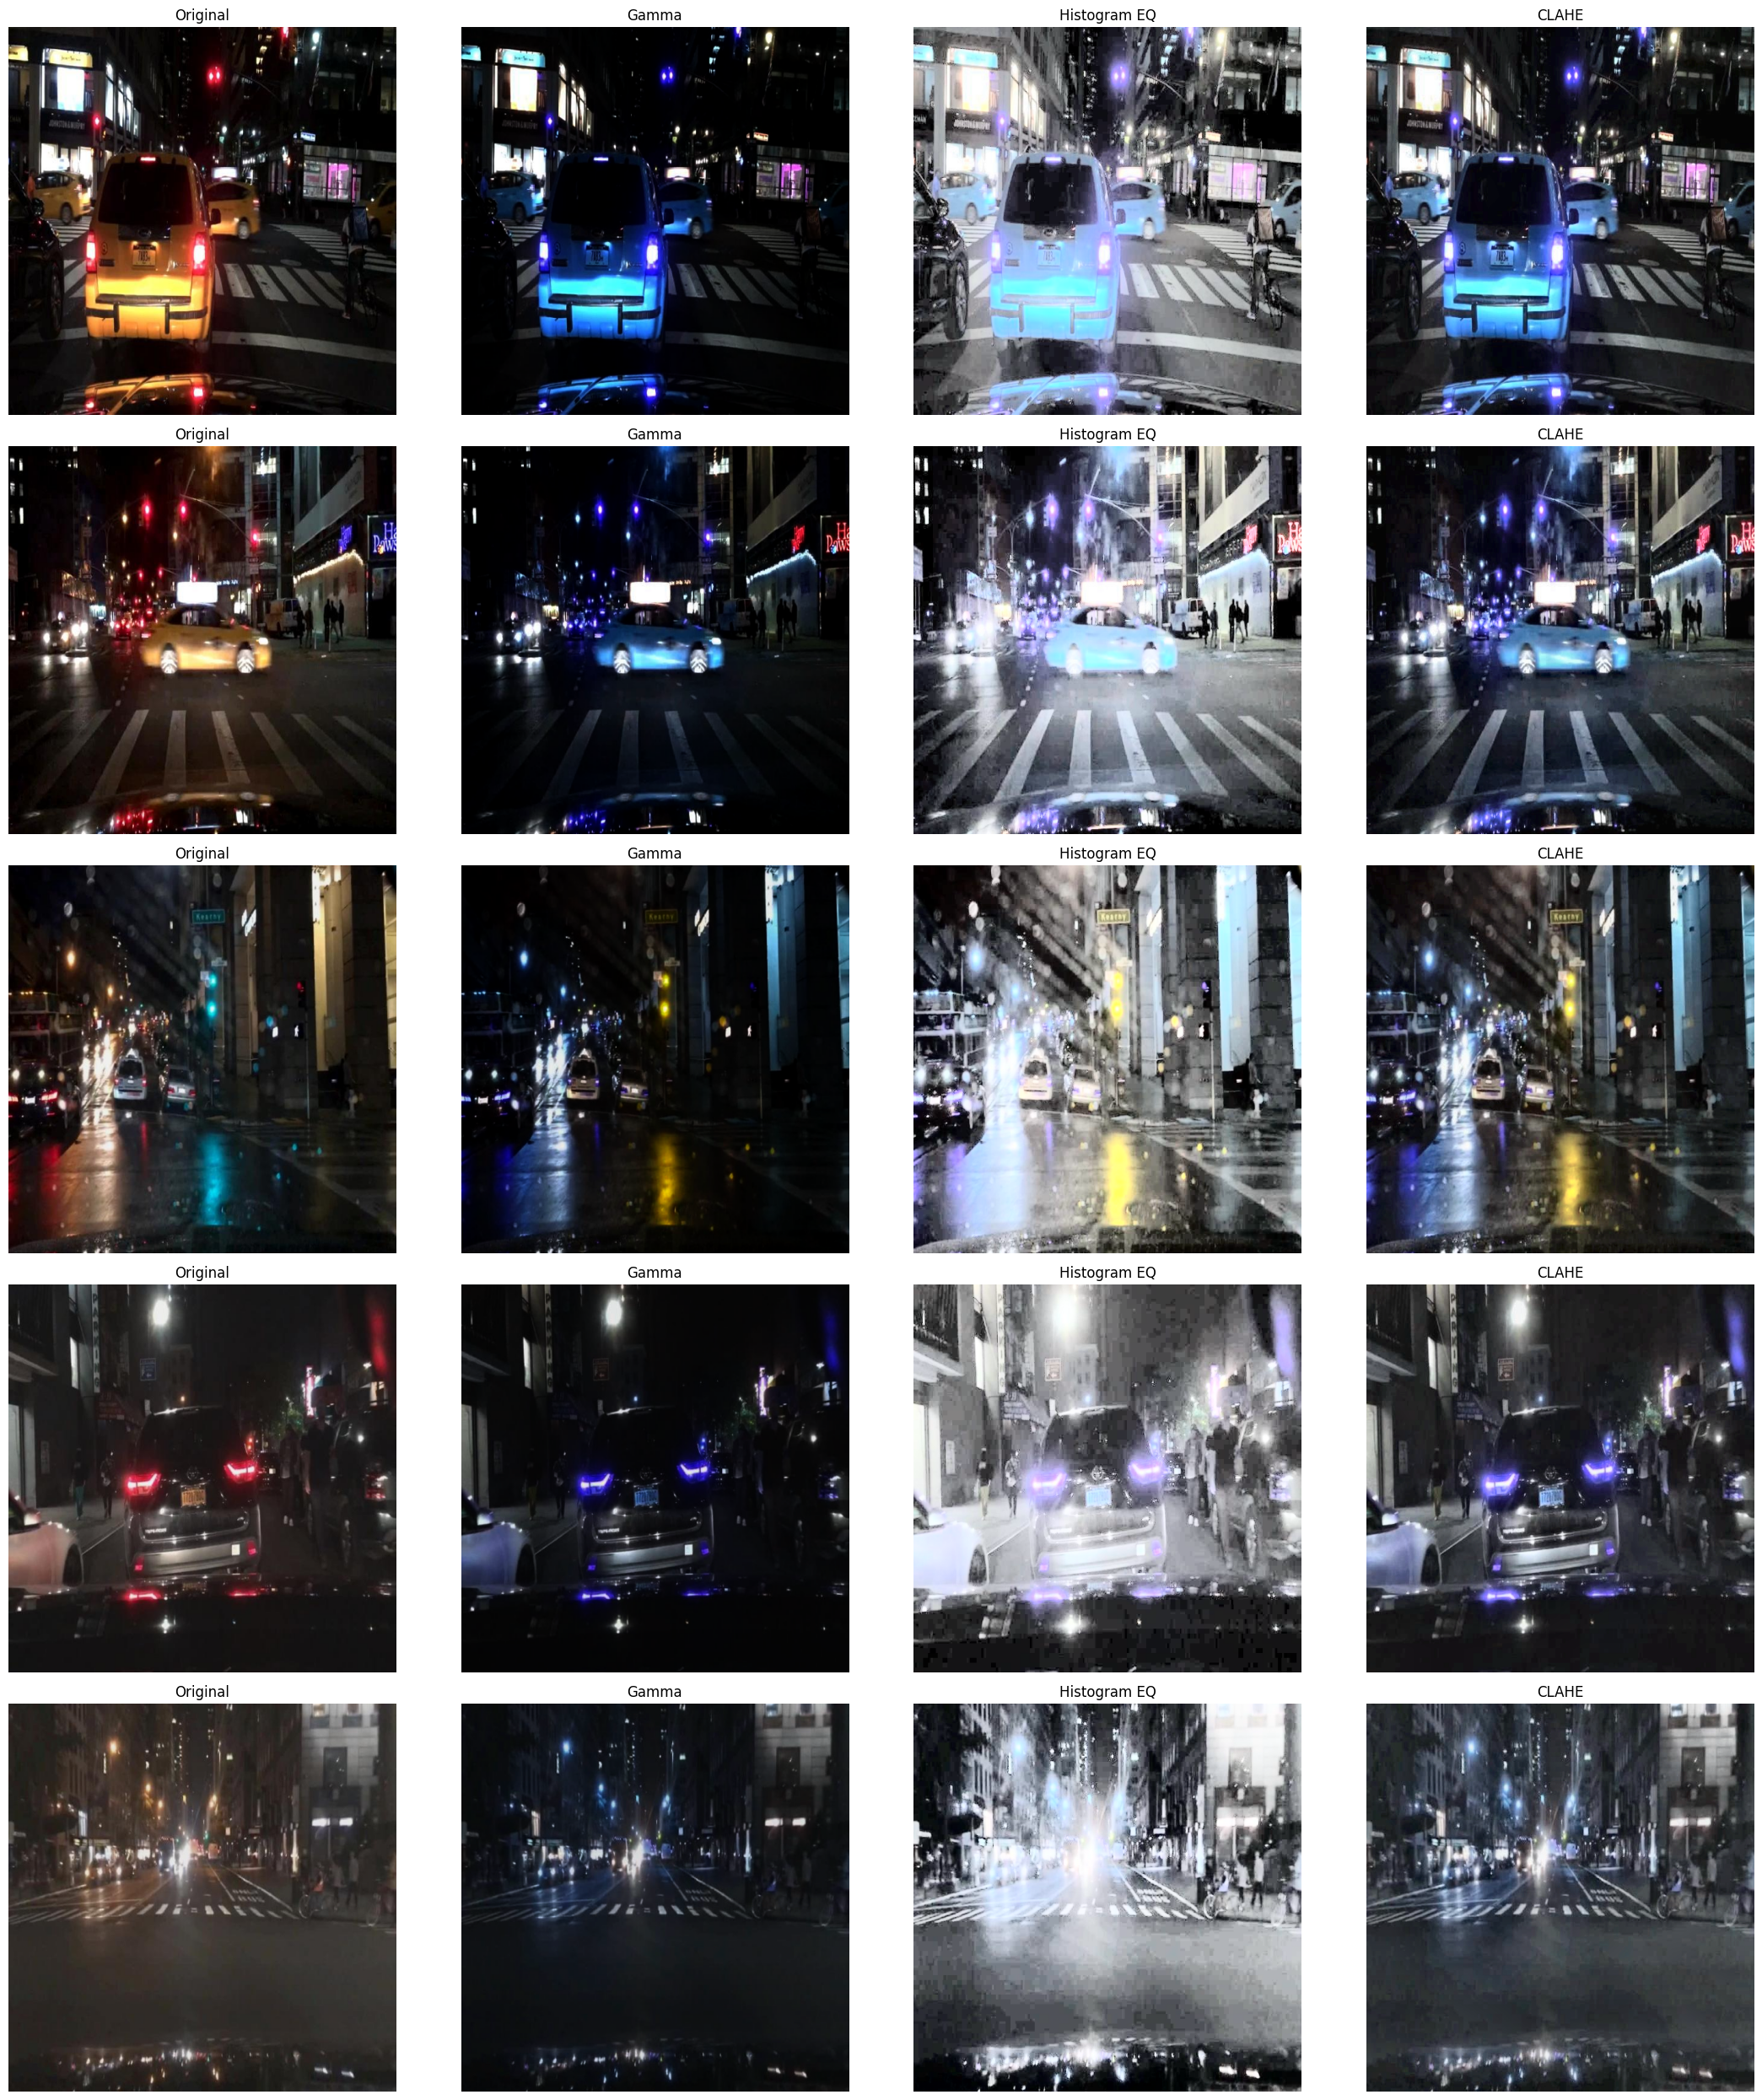

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

# pick some images
sample = [f for f in os.listdir(train_path) if f.lower().endswith(('.jpg','.png'))][:5]

plt.figure(figsize=(22, 5 * len(sample)))

for i, img_name in enumerate(sample):
    img = cv2.imread(os.path.join(train_path, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_gamma, img_he, img_clahe = enhance_image(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    imgs = [img, img_gamma, img_he, img_clahe]
    titles = ["Original", "Gamma", "Histogram EQ", "CLAHE"]

    for j in range(4):
        plt.subplot(len(sample), 4, i*4 + j + 1)
        plt.imshow(imgs[j])
        plt.title(titles[j], fontsize=12)
        plt.axis("off")

plt.tight_layout()
plt.show()


## **5. Enhancing using CLAHE and Gama Correction**

In [ ]:
import shutil

orig_path = dataset.location
enhanced_path = "/content/enhanced_lowlight"
if os.path.exists(enhanced_path):
    shutil.rmtree(enhanced_path)

shutil.copytree(orig_path, enhanced_path)

# Enhance only training images
train_dir = f"{enhanced_path}/train/images"

print("Enhancing training images...")

for img_name in tqdm(os.listdir(train_dir)):
    path = f"{train_dir}/{img_name}"
    img = cv2.imread(path)

    # Apply enhancement (choose one or combine)
    enhanced = clahe_enhance(img)
    enhanced = gamma_correct(enhanced, gamma=1.4)

    cv2.imwrite(path, enhanced)

print("Enhanced dataset ready:", enhanced_path)


Enhancing training images...


100%|██████████| 700/700 [00:11<00:00, 62.36it/s]

Enhanced dataset ready: /content/enhanced_lowlight


## **6. Training Original Model**

In [ ]:
from ultralytics import YOLO

model_orig = YOLO("yolov8n.pt")

results_orig = model_orig.train(
    data=f"{orig_path}/data.yaml",
    epochs=100,
    imgsz=640,
    name="yolo_original"
)


Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Low-light-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_original, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=T

## **7. Training Enhanced Model**

In [ ]:
model_enh = YOLO("yolov8n.pt")

results_enh = model_enh.train(
    data=f"{enhanced_path}/data.yaml",
    epochs=100,
    imgsz=640,
    name="yolo_enhanced"
)


Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/enhanced_lowlight/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_enhanced, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, p

## **8. Performance Evaluation**

In [ ]:
print("📊 ORIGINAL MODEL PERFORMANCE:")
res_orig = model_orig.val()
orig_metrics = extract_metrics(res_orig)

print("\n📊 ENHANCED MODEL PERFORMANCE:")
res_enh = model_enh.val(data=f"{enhanced_path}/data.yaml")
enh_metrics = extract_metrics(res_enh)


📊 ORIGINAL MODEL PERFORMANCE:
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1125.2±612.7 MB/s, size: 35.0 KB)
val: Scanning /content/Low-light-1/valid/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 200/200 401.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 2.8it/s 4.7s
                   all        200        650      0.742      0.767      0.801      0.395
               Vehicle        196        581       0.78      0.773      0.827      0.427
                person         35         69      0.705      0.761      0.774      0.364
Speed: 5.2ms preprocess, 4.6ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /content/runs/detect/val6

📊 ENHANCED MODEL PERFORMANCE:
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0

## **9. Accuracy Table**

In [ ]:
import numpy as np

def safe_convert(x):
    """Convert YOLO metric values into a clean scalar."""
    if x is None:
        return None

    # If input is a numpy array
    if isinstance(x, np.ndarray):
        if x.size == 1:
            return float(x[0])
        else:
            return float(np.mean(x))   # take average if multiple values exist

    # If input is a list
    if isinstance(x, list):
        if len(x) == 1:
            return float(x[0])
        else:
            return float(sum(x) / len(x))

    # Already scalar
    try:
        return float(x)
    except:
        return x
def get_value(obj, name):
    return getattr(obj, name) if hasattr(obj, name) else None

def first_not_none(*vals):
    for v in vals:
        if v is not None:
            return v
    return None

def extract_metrics(result):
    """Extract YOLO metrics safely with full compatibility."""
    box = result.box  # YOLO metrics object

    precision = first_not_none(get_value(box, "precision"), get_value(box, "mp"))
    recall = first_not_none(get_value(box, "recall"), get_value(box, "mr"))
    map50 = get_value(box, "map50")
    map5095 = first_not_none(get_value(box, "map"), get_value(box, "map5095"))
    f1 = first_not_none(get_value(box, "f1"), get_value(box, "mf1"))

    return {
        "Precision": safe_convert(precision),
        "Recall": safe_convert(recall),
        "mAP50": safe_convert(map50),
        "mAP50-95": safe_convert(map5095),
        "F1 Score": safe_convert(f1),
    }
import pandas as pd

# Example DataFrame
df = pd.DataFrame({
    "Original Model": orig_metrics,
    "Enhanced Model": enh_metrics
})

# Display with borders
df_styled = df.style.set_table_styles([
    {'selector': 'th', 'props': [('border', '1px solid black'), ('padding', '4px')]},
    {'selector': 'td', 'props': [('border', '1px solid black'), ('padding', '4px')]}
]).set_properties(**{'text-align': 'center'})

df_styled



## **10. Performance Comparison**

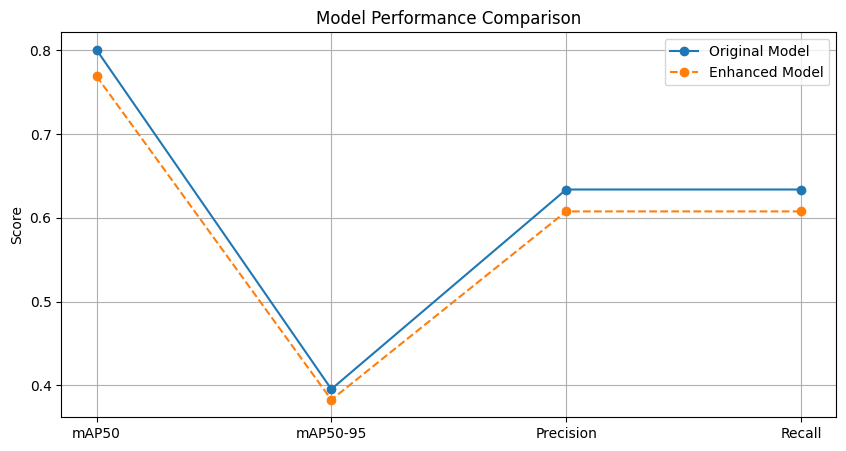

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract mAP values from YOLO results object
orig_map50 = res_orig.box.map50
orig_map   = res_orig.box.map

enh_map50  = res_enh.box.map50
enh_map    = res_enh.box.map

# Extract confusion matrix values
cm_orig = res_orig.confusion_matrix
cm_enh  = res_enh.confusion_matrix

# Precision & Recall calculation
orig_precision = np.sum(cm_orig.matrix.diagonal()) / np.sum(cm_orig.matrix, axis=0).sum()
orig_recall    = np.sum(cm_orig.matrix.diagonal()) / np.sum(cm_orig.matrix, axis=1).sum()

enh_precision  = np.sum(cm_enh.matrix.diagonal()) / np.sum(cm_enh.matrix, axis=0).sum()
enh_recall     = np.sum(cm_enh.matrix.diagonal()) / np.sum(cm_enh.matrix, axis=1).sum()

# Labels
labels = ["mAP50", "mAP50-95", "Precision", "Recall"]

orig_scores = [orig_map50, orig_map, orig_precision, orig_recall]
enh_scores  = [enh_map50,  enh_map,  enh_precision,  enh_recall]

# Plot
plt.figure(figsize=(10,5))
plt.plot(labels, orig_scores, marker='o', label="Original Model")
plt.plot(labels, enh_scores, marker='o', linestyle='--', label="Enhanced Model")

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.grid()
plt.legend()
plt.show()


## **11. Detection**

In [ ]:
import os
import random
import matplotlib.pyplot as plt

orig_img_dir = f"{orig_path}/valid/images"

# Pick random 5 images
sample_images = random.sample(os.listdir(orig_img_dir), 5)

# Create a figure: 5 rows, 2 columns
fig, axes = plt.subplots(len(sample_images), 2, figsize=(16, 4 * len(sample_images)))

for i, img_name in enumerate(sample_images):

    img_path = os.path.join(orig_img_dir, img_name)

    # Model predictions
    r1 = model_orig(img_path)
    r2 = model_enh(img_path)

    # ORIGINAL
    axes[i, 0].imshow(r1[0].plot())
    axes[i, 0].axis("off")

    # ENHANCED
    axes[i, 1].imshow(r2[0].plot())
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


NameError: name 'orig_path' is not defined

## **12. Precision-Recall Table**

In [ ]:
import os
import glob
import cv2
import torch
import pandas as pd
from ultralytics.utils.metrics import bbox_iou

def evaluate_image_level(model, img_dir, label_dir, iou_th=0.5):
    rows = []

    image_files = sorted(
        glob.glob(os.path.join(img_dir, "*.jpg")) +
        glob.glob(os.path.join(img_dir, "*.png")) +
        glob.glob(os.path.join(img_dir, "*.jpeg"))
    )

    for img_path in image_files:
        name = os.path.basename(img_path)

        # -------------------------
        # Load image (to get width & height)
        # -------------------------
        img = cv2.imread(img_path)
        if img is None:
            continue
        h_img, w_img = img.shape[:2]

        # -------------------------
        # Load GT label
        # -------------------------
        label_path = os.path.join(label_dir, name.rsplit(".", 1)[0] + ".txt")
        gt = []

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    cls, cx, cy, w, h = map(float, line.strip().split())

                    # Convert normalized xywh → absolute xyxy
                    x1 = (cx - w/2) * w_img
                    y1 = (cy - h/2) * h_img
                    x2 = (cx + w/2) * w_img
                    y2 = (cy + h/2) * h_img

                    gt.append([x1, y1, x2, y2])

        gt = torch.tensor(gt)
        gt_count = len(gt)

        # -------------------------
        # Predict using model
        # -------------------------
        results = model(img_path)[0]
        pred_boxes = results.boxes.xyxy.cpu() if len(results.boxes) else torch.empty((0,4))

        correct = 0
        incorrect = 0
        used_gt = set()

        # -------------------------
        # IoU matching
        # -------------------------
        if len(pred_boxes) > 0 and gt_count > 0:
            for pb in pred_boxes:
                ious = bbox_iou(pb.unsqueeze(0), gt)

                best_iou = ious.max().item()
                idx = ious.argmax().item()

                if best_iou >= iou_th and idx not in used_gt:
                    correct += 1
                    used_gt.add(idx)
                else:
                    incorrect += 1
        else:
            incorrect = len(pred_boxes)

        missing = gt_count - correct

        recall = correct / gt_count if gt_count > 0 else 0
        precision = correct / (correct + incorrect) if (correct + incorrect) > 0 else 0

        rows.append({
            "Image": name,
            "GT Count": gt_count,
            "Correct": correct,
            "Incorrect": incorrect,
            "Missing": missing,
            "Recall": round(recall, 3),
            "Precision": round(precision, 3)
        })

    return pd.DataFrame(rows)


In [ ]:
model_orig = YOLO("/content/runs/detect/yolo_original/weights/best.pt")
model_enh  = YOLO("/content/runs/detect/yolo_enhanced/weights/best.pt")


In [ ]:
orig_table = evaluate_image_level(
    model_orig,
    "/content/Low-light-1/valid/images",
    "/content/Low-light-1/valid/labels"
)
orig_table



image 1/1 /content/Low-light-1/valid/images/03935c73-98cac3ec_augmented_1_jpg.rf.dc583c446a4e3ef468058c0809b52096.jpg: 640x640 2 Vehicles, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/Low-light-1/valid/images/05476b39-9d783f66_augmented_1_jpg.rf.b44c9d8b9353a17acd617324417cf92b.jpg: 640x640 1 Vehicle, 4 persons, 7.1ms
Speed: 1.6ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/Low-light-1/valid/images/0568273b-0fb92589_augmented_2_jpg.rf.c08cc0dcb70a508b28c4a2100bf78223.jpg: 640x640 5 Vehicles, 7.1ms
Speed: 1.3ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/Low-light-1/valid/images/06265565-67924b70_augmented_1_jpg.rf.7610470c190aeb67b44f558a07472ff1.jpg: 640x640 5 Vehicles, 7.3ms
Speed: 1.4ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/Lo

Image  GT Count  Correct  \
0    03935c73-98cac3ec_augmented_1_jpg.rf.dc583c446...         2        2   
1    05476b39-9d783f66_augmented_1_jpg.rf.b44c9d8b9...         6        5   
2    0568273b-0fb92589_augmented_2_jpg.rf.c08cc0dcb...         4        3   
3    06265565-67924b70_augmented_1_jpg.rf.7610470c1...         7        5   
4    0824493b-5300b065_augmented_1_jpg.rf.ff0db60f5...         3        3   
..                                                 ...       ...      ...   
195  c046b4c6-420f75ad_augmented_0_jpg.rf.c7deace75...         5        5   
196  c17b2387-b53d9933_augmented_0_jpg.rf.f9a85c209...         1        0   
197  c3639d96-b9928b16_augmented_1_jpg.rf.a8629ad09...         4        4   
198  c3639d96-b9928b16_augmented_2_jpg.rf.88e06699c...         4        4   
199  c3993f07-cc084164_augmented_0_jpg.rf.2051bdc5b...         2        2   

     Incorrect  Missing  Recall  Precision  
0            0        0   1.000      1.000  
1            0        1   0.833      1.000  
2            2        1   0.750      0.600  
3            0        2   0.714      1.000  
4            0        0   1.000      1.000  
..         ...      ...     ...        ...  
195          2        0   1.000      0.714  
196          0        1   0.000      0.000  
197          1        0   1.000      0.800  
198          1        0   1.000      0.800  
199          1        0   1.000      0.667  

[200 rows x 7 columns]

from matplotlib import pyplot as plt
orig_table['GT Count'].plot(kind='hist', bins=20, title='GT Count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
orig_table['Correct'].plot(kind='hist', bins=20, title='Correct')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
orig_table['Incorrect'].plot(kind='hist', bins=20, title='Incorrect')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
orig_table['Missing'].plot(kind='hist', bins=20, title='Missing')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
orig_table.plot(kind='scatter', x='GT Count', y='Correct', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
orig_table.plot(kind='scatter', x='Correct', y='Incorrect', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
orig_table.plot(kind='scatter', x='Incorrect', y='Missing', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
orig_table.plot(kind='scatter', x='Missing', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
orig_table['GT Count'].plot(kind='line', figsize=(8, 4), title='GT Count')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
orig_table['Correct'].plot(kind='line', figsize=(8, 4), title='Correct')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
orig_table['Incorrect'].plot(kind='line', figsize=(8, 4), title='Incorrect')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
orig_table['Missing'].plot(kind='line', figsize=(8, 4), title='Missing')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
enh_table = evaluate_image_level(
    model_enh,
    "/content/enhanced_lowlight/valid/images",
    "/content/enhanced_lowlight/valid/labels"
)
enh_table



image 1/1 /content/enhanced_lowlight/valid/images/03935c73-98cac3ec_augmented_1_jpg.rf.dc583c446a4e3ef468058c0809b52096.jpg: 640x640 3 Vehicles, 7.1ms
Speed: 1.5ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/enhanced_lowlight/valid/images/05476b39-9d783f66_augmented_1_jpg.rf.b44c9d8b9353a17acd617324417cf92b.jpg: 640x640 1 Vehicle, 6 persons, 7.1ms
Speed: 1.5ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/enhanced_lowlight/valid/images/0568273b-0fb92589_augmented_2_jpg.rf.c08cc0dcb70a508b28c4a2100bf78223.jpg: 640x640 4 Vehicles, 7.1ms
Speed: 1.4ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/enhanced_lowlight/valid/images/06265565-67924b70_augmented_1_jpg.rf.7610470c190aeb67b44f558a07472ff1.jpg: 640x640 3 Vehicles, 7.1ms
Speed: 1.3ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640

Image  GT Count  Correct  \
0    03935c73-98cac3ec_augmented_1_jpg.rf.dc583c446...         2        2   
1    05476b39-9d783f66_augmented_1_jpg.rf.b44c9d8b9...         6        6   
2    0568273b-0fb92589_augmented_2_jpg.rf.c08cc0dcb...         4        3   
3    06265565-67924b70_augmented_1_jpg.rf.7610470c1...         7        3   
4    0824493b-5300b065_augmented_1_jpg.rf.ff0db60f5...         3        3   
..                                                 ...       ...      ...   
195  c046b4c6-420f75ad_augmented_0_jpg.rf.c7deace75...         5        5   
196  c17b2387-b53d9933_augmented_0_jpg.rf.f9a85c209...         1        0   
197  c3639d96-b9928b16_augmented_1_jpg.rf.a8629ad09...         4        3   
198  c3639d96-b9928b16_augmented_2_jpg.rf.88e06699c...         4        4   
199  c3993f07-cc084164_augmented_0_jpg.rf.2051bdc5b...         2        2   

     Incorrect  Missing  Recall  Precision  
0            1        0   1.000      0.667  
1            1        0   1.000      0.857  
2            1        1   0.750      0.750  
3            0        4   0.429      1.000  
4            0        0   1.000      1.000  
..         ...      ...     ...        ...  
195          4        0   1.000      0.556  
196          0        1   0.000      0.000  
197          0        1   0.750      1.000  
198          0        0   1.000      1.000  
199          0        0   1.000      1.000  

[200 rows x 7 columns]

from matplotlib import pyplot as plt
enh_table['GT Count'].plot(kind='hist', bins=20, title='GT Count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
enh_table['Correct'].plot(kind='hist', bins=20, title='Correct')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
enh_table['Incorrect'].plot(kind='hist', bins=20, title='Incorrect')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
enh_table['Missing'].plot(kind='hist', bins=20, title='Missing')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
enh_table.plot(kind='scatter', x='GT Count', y='Correct', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
enh_table.plot(kind='scatter', x='Correct', y='Incorrect', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
enh_table.plot(kind='scatter', x='Incorrect', y='Missing', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
enh_table.plot(kind='scatter', x='Missing', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
enh_table['GT Count'].plot(kind='line', figsize=(8, 4), title='GT Count')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
enh_table['Correct'].plot(kind='line', figsize=(8, 4), title='Correct')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
enh_table['Incorrect'].plot(kind='line', figsize=(8, 4), title='Incorrect')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
enh_table['Missing'].plot(kind='line', figsize=(8, 4), title='Missing')
plt.gca().spines[['top', 'right']].set_visible(False)

## **13. Accuracy and Loss Curves**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Paths
orig_csv = "/content/runs/detect/yolo_original/results.csv"
enh_csv  = "/content/runs/detect/yolo_enhanced/results.csv"

# Load Data
orig = pd.read_csv(orig_csv)
enh  = pd.read_csv(enh_csv)

# Check columns
print("Columns:", orig.columns)


Columns: Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


ORIGINAL COLUMNS: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']
ENHANCED COLUMNS: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


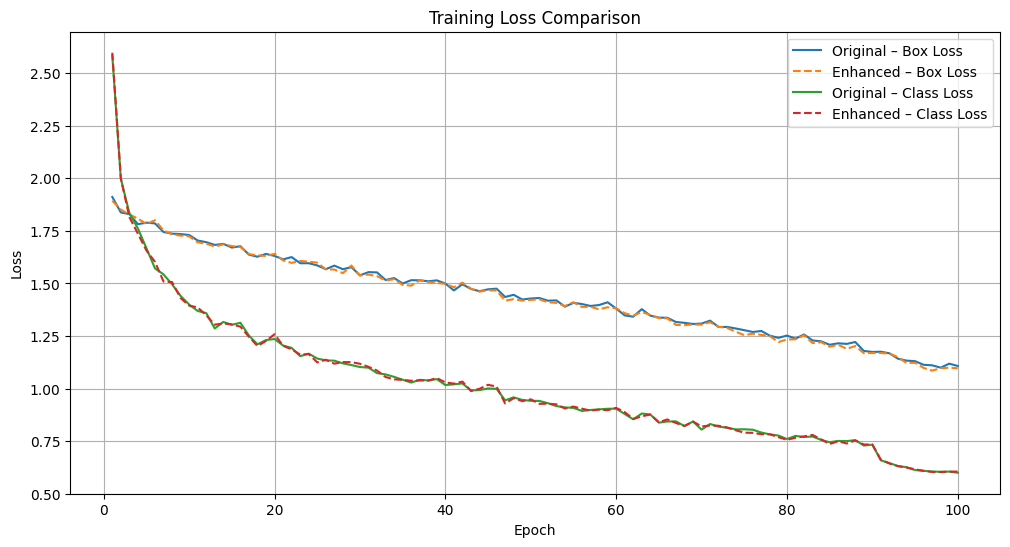

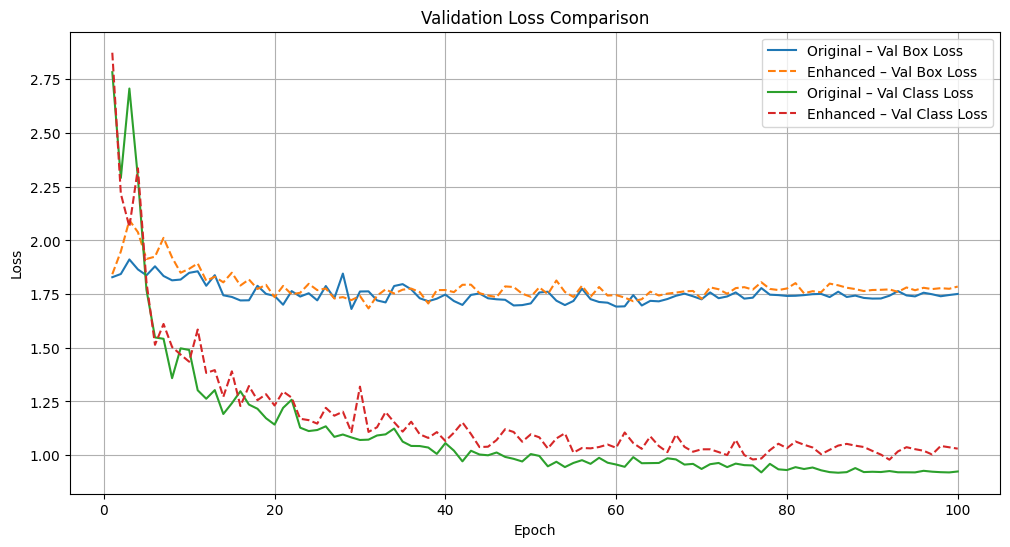

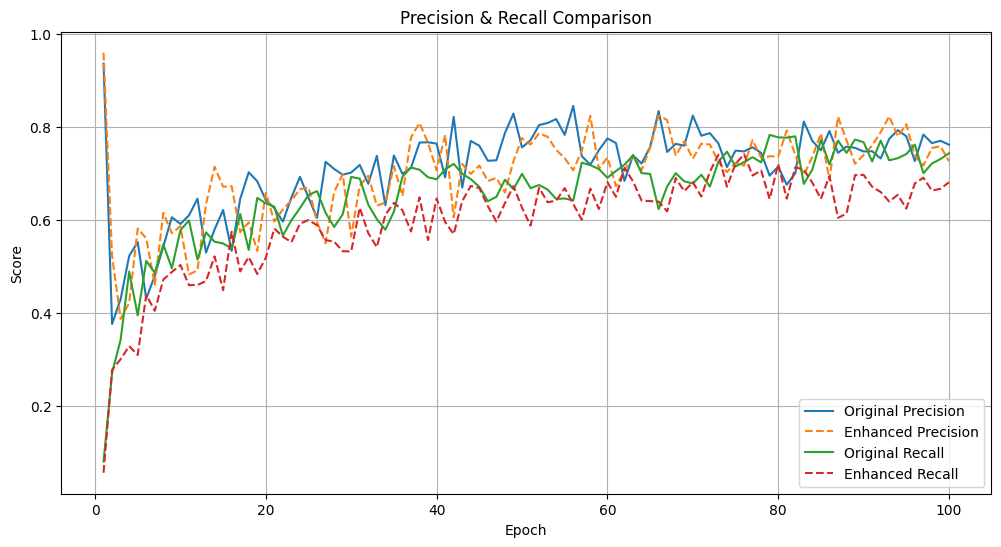

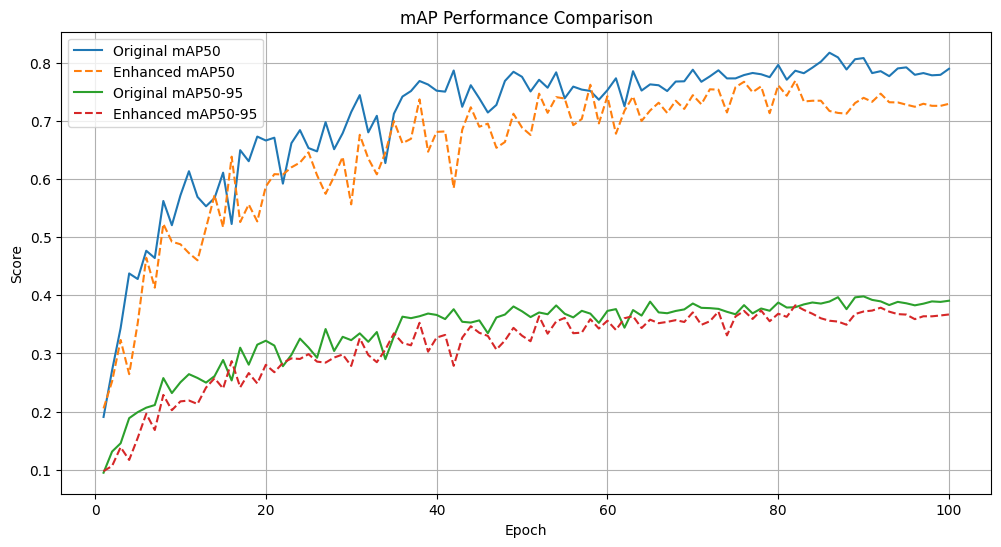


All plots saved in: /content/plots


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ============================================
# 0) CREATE FOLDER TO SAVE PLOTS
# ============================================
save_dir = "/content/plots"
os.makedirs(save_dir, exist_ok=True)

# ============================================
# 1) LOAD CSV FILES
# ============================================
orig_csv = "/content/runs/detect/yolo_original/results.csv"
enh_csv = "/content/runs/detect/yolo_enhanced/results.csv"

df_orig = pd.read_csv(orig_csv)
df_enh = pd.read_csv(enh_csv)

print("ORIGINAL COLUMNS:", df_orig.columns.tolist())
print("ENHANCED COLUMNS:", df_enh.columns.tolist())

# ============================================
# 2) TRAINING LOSSES
# ============================================
plt.figure(figsize=(12,6))
plt.plot(df_orig["epoch"], df_orig["train/box_loss"], label="Original – Box Loss")
plt.plot(df_enh["epoch"], df_enh["train/box_loss"], label="Enhanced – Box Loss", linestyle="--")
plt.plot(df_orig["epoch"], df_orig["train/cls_loss"], label="Original – Class Loss")
plt.plot(df_enh["epoch"], df_enh["train/cls_loss"], label="Enhanced – Class Loss", linestyle="--")
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.savefig(f"{save_dir}/training_loss.png", dpi=300)
plt.show()

# ============================================
# 3) VALIDATION LOSSES
# ============================================
plt.figure(figsize=(12,6))
plt.plot(df_orig["epoch"], df_orig["val/box_loss"], label="Original – Val Box Loss")
plt.plot(df_enh["epoch"], df_enh["val/box_loss"], label="Enhanced – Val Box Loss", linestyle="--")
plt.plot(df_orig["epoch"], df_orig["val/cls_loss"], label="Original – Val Class Loss")
plt.plot(df_enh["epoch"], df_enh["val/cls_loss"], label="Enhanced – Val Class Loss", linestyle="--")
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.savefig(f"{save_dir}/validation_loss.png", dpi=300)
plt.show()

# ============================================
# 4) PRECISION & RECALL
# ============================================
plt.figure(figsize=(12,6))
plt.plot(df_orig["epoch"], df_orig["metrics/precision(B)"], label="Original Precision")
plt.plot(df_enh["epoch"], df_enh["metrics/precision(B)"], label="Enhanced Precision", linestyle="--")
plt.plot(df_orig["epoch"], df_orig["metrics/recall(B)"], label="Original Recall")
plt.plot(df_enh["epoch"], df_enh["metrics/recall(B)"], label="Enhanced Recall", linestyle="--")
plt.title("Precision & Recall Comparison")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.grid()
plt.legend()
plt.savefig(f"{save_dir}/precision_recall.png", dpi=300)
plt.show()

# ============================================
# 5) mAP50 & mAP50-95
# ============================================
plt.figure(figsize=(12,6))
plt.plot(df_orig["epoch"], df_orig["metrics/mAP50(B)"], label="Original mAP50")
plt.plot(df_enh["epoch"], df_enh["metrics/mAP50(B)"], label="Enhanced mAP50", linestyle="--")
plt.plot(df_orig["epoch"], df_orig["metrics/mAP50-95(B)"], label="Original mAP50-95")
plt.plot(df_enh["epoch"], df_enh["metrics/mAP50-95(B)"], label="Enhanced mAP50-95", linestyle="--")
plt.title("mAP Performance Comparison")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.grid()
plt.legend()
plt.savefig(f"{save_dir}/map_scores.png", dpi=300)
plt.show()

print(f"\nAll plots saved in: {save_dir}")
